In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn
import seaborn as sns
import os

Read input data

In [2]:
shops = pd.read_csv("data/shops.csv")
item_categories = pd.read_csv("data/item_categories.csv")
sales_train = pd.read_csv("data/sales_train.csv")
items = pd.read_csv("data/items.csv")

test = pd.read_csv("data/test.csv")
sample_submission = pd.read_csv("data/sample_submission.csv")

## Train an XGBoost model

In [4]:
new_train = pd.read_pickle('train_test.pkl')

### a. Set up an XGBoost model and perform hyperparameter tuning

In [5]:
from xgboost import XGBRegressor
from xgboost import plot_importance
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error as mse

- We use a coarse grid to do hyperparameter tuning
- Train: date_block_num = [12, 32]; Validation: date_block_num = 33

In [6]:
x_train = new_train[(new_train.date_block_num >= 12) & (new_train.date_block_num <= 32)]
x_val = new_train[new_train.date_block_num == 33]
    
y_train = x_train[['item_cnt_sum']]
y_val = x_val[['item_cnt_sum']]
x_train = x_train.drop(columns=['item_cnt_sum']).fillna(0)
x_val = x_val.drop(columns=['item_cnt_sum']).fillna(0)

The dataset is too large for gridsearchcv, so we do the hyperparameter search using for loops

In [46]:
min_child_weight_list = [10, 100, 300]

for min_child_weight in min_child_weight_list:

    print("******************* %4d *******************\n\n" % min_child_weight)
    
    model = XGBRegressor(n_estimators=200,
                         max_depth=8,
                         min_child_weight=min_child_weight, 
                         colsample_bytree=0.8, 
                         subsample=0.8,
                         eta=0.3,
                         seed=42)
    
    # Fit the model
    model.fit(
        x_train, 
        y_train, 
        eval_metric="rmse", 
        eval_set=[(x_train, y_train), (x_val, y_val)], 
        verbose=True,
        early_stopping_rounds = 10)
    
    # Evaluate the model
    score = np.sqrt(mse(y_val, model.predict(x_val)))
    
    print('\n\n min_child_weight %4d, RMSE: %.3f' % (min_child_weight, score))

*******************   10 *******************


[21:14:40] Tree method is automatically selected to be 'approx' for faster speed. to use old behavior(exact greedy algorithm on single machine), set tree_method to 'exact'
[0]	validation_0-rmse:1.15726	validation_1-rmse:1.12433
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rmse hasn't improved in 10 rounds.
[1]	validation_0-rmse:1.11458	validation_1-rmse:1.09425
[2]	validation_0-rmse:1.07374	validation_1-rmse:1.06485
[3]	validation_0-rmse:1.0386	validation_1-rmse:1.0409
[4]	validation_0-rmse:1.01136	validation_1-rmse:1.02041
[5]	validation_0-rmse:0.985414	validation_1-rmse:1.00165
[6]	validation_0-rmse:0.964917	validation_1-rmse:0.989031
[7]	validation_0-rmse:0.947471	validation_1-rmse:0.978084
[8]	validation_0-rmse:0.932755	validation_1-rmse:0.968874
[9]	validation_0-rmse:0.918151	validation_1-rmse:0.959893
[10]	validation_0-rmse:0.906066	validation_1-rmse:0.952

[34]	validation_0-rmse:0.834219	validation_1-rmse:0.914566
[35]	validation_0-rmse:0.833321	validation_1-rmse:0.915373
[36]	validation_0-rmse:0.832421	validation_1-rmse:0.915445
[37]	validation_0-rmse:0.831604	validation_1-rmse:0.91546
[38]	validation_0-rmse:0.830399	validation_1-rmse:0.915349
[39]	validation_0-rmse:0.829853	validation_1-rmse:0.915233
[40]	validation_0-rmse:0.829256	validation_1-rmse:0.91537
[41]	validation_0-rmse:0.828814	validation_1-rmse:0.915407
[42]	validation_0-rmse:0.828189	validation_1-rmse:0.915177
[43]	validation_0-rmse:0.827532	validation_1-rmse:0.915556
[44]	validation_0-rmse:0.826678	validation_1-rmse:0.915609
Stopping. Best iteration:
[34]	validation_0-rmse:0.834219	validation_1-rmse:0.914566



 min_child_weight  300, RMSE: 0.915


In [47]:
colsample_bytree_list = [0.5, 0.6, 0.7, 0.8]

for colsample_bytree in colsample_bytree_list:

    print("******************* %.1f *******************\n\n" % colsample_bytree)
    
    model = XGBRegressor(n_estimators=200,
                         max_depth=8,
                         min_child_weight=100, 
                         colsample_bytree=colsample_bytree, 
                         subsample=0.8,
                         eta=0.3,
                         seed=42)
    
    # Fit the model
    model.fit(
        x_train, 
        y_train, 
        eval_metric="rmse", 
        eval_set=[(x_train, y_train), (x_val, y_val)], 
        verbose=True,
        early_stopping_rounds = 10)
    
    # Evaluate the model
    score = np.sqrt(mse(y_val, model.predict(x_val)))
    
    print('\n\n colsample_bytree %.1f, RMSE: %.3f' % (colsample_bytree, score))

******************* 0.5 *******************


[23:24:44] Tree method is automatically selected to be 'approx' for faster speed. to use old behavior(exact greedy algorithm on single machine), set tree_method to 'exact'
[0]	validation_0-rmse:1.15861	validation_1-rmse:1.12417
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rmse hasn't improved in 10 rounds.
[1]	validation_0-rmse:1.11774	validation_1-rmse:1.0938
[2]	validation_0-rmse:1.08238	validation_1-rmse:1.06755
[3]	validation_0-rmse:1.05187	validation_1-rmse:1.04703
[4]	validation_0-rmse:1.02847	validation_1-rmse:1.03057
[5]	validation_0-rmse:1.0019	validation_1-rmse:1.01314
[6]	validation_0-rmse:0.984646	validation_1-rmse:1.00073
[7]	validation_0-rmse:0.969105	validation_1-rmse:0.989176
[8]	validation_0-rmse:0.953708	validation_1-rmse:0.978258
[9]	validation_0-rmse:0.936907	validation_1-rmse:0.967726
[10]	validation_0-rmse:0.922644	validation_1-rmse:0.958866

[16]	validation_0-rmse:0.867625	validation_1-rmse:0.931934
[17]	validation_0-rmse:0.862863	validation_1-rmse:0.929462
[18]	validation_0-rmse:0.858711	validation_1-rmse:0.927994
[19]	validation_0-rmse:0.855021	validation_1-rmse:0.926024
[20]	validation_0-rmse:0.852207	validation_1-rmse:0.924336
[21]	validation_0-rmse:0.849066	validation_1-rmse:0.922208
[22]	validation_0-rmse:0.846307	validation_1-rmse:0.921382
[23]	validation_0-rmse:0.843616	validation_1-rmse:0.920174
[24]	validation_0-rmse:0.841427	validation_1-rmse:0.919337
[25]	validation_0-rmse:0.839848	validation_1-rmse:0.918507
[26]	validation_0-rmse:0.837952	validation_1-rmse:0.917466
[27]	validation_0-rmse:0.836547	validation_1-rmse:0.916803
[28]	validation_0-rmse:0.83507	validation_1-rmse:0.91648
[29]	validation_0-rmse:0.83361	validation_1-rmse:0.916058
[30]	validation_0-rmse:0.831847	validation_1-rmse:0.914858
[31]	validation_0-rmse:0.830437	validation_1-rmse:0.914786
[32]	validation_0-rmse:0.829269	validation_1-rmse:0.914736


In [7]:
subsample_list = [0.6, 0.7, 0.8, 0.9]

for subsample in subsample_list:

    print("******************* %.1f *******************\n\n" % subsample)
    
    model = XGBRegressor(n_estimators=200,
                         max_depth=8,
                         min_child_weight=100, 
                         colsample_bytree=0.7, 
                         subsample=subsample,
                         eta=0.3,
                         seed=42)
    
    # Fit the model
    model.fit(
        x_train, 
        y_train, 
        eval_metric="rmse", 
        eval_set=[(x_train, y_train), (x_val, y_val)], 
        verbose=True,
        early_stopping_rounds = 10)
    
    # Evaluate the model
    score = np.sqrt(mse(y_val, model.predict(x_val)))
    
    print('\n\n subsample %.1f, RMSE: %.3f' % (subsample, score))

******************* 0.6 *******************


[19:59:33] Tree method is automatically selected to be 'approx' for faster speed. to use old behavior(exact greedy algorithm on single machine), set tree_method to 'exact'
[0]	validation_0-rmse:1.15766	validation_1-rmse:1.12426
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rmse hasn't improved in 10 rounds.
[1]	validation_0-rmse:1.11617	validation_1-rmse:1.09351
[2]	validation_0-rmse:1.0799	validation_1-rmse:1.06815
[3]	validation_0-rmse:1.0446	validation_1-rmse:1.04423
[4]	validation_0-rmse:1.01797	validation_1-rmse:1.02628
[5]	validation_0-rmse:0.991225	validation_1-rmse:1.00775
[6]	validation_0-rmse:0.971416	validation_1-rmse:0.99592
[7]	validation_0-rmse:0.954423	validation_1-rmse:0.984456
[8]	validation_0-rmse:0.940499	validation_1-rmse:0.974616
[9]	validation_0-rmse:0.925622	validation_1-rmse:0.965159
[10]	validation_0-rmse:0.913173	validation_1-rmse:0.95657

[14]	validation_0-rmse:0.879097	validation_1-rmse:0.938517
[15]	validation_0-rmse:0.87314	validation_1-rmse:0.935854
[16]	validation_0-rmse:0.867625	validation_1-rmse:0.931934
[17]	validation_0-rmse:0.862863	validation_1-rmse:0.929462
[18]	validation_0-rmse:0.858711	validation_1-rmse:0.927994
[19]	validation_0-rmse:0.855021	validation_1-rmse:0.926024
[20]	validation_0-rmse:0.852207	validation_1-rmse:0.924336
[21]	validation_0-rmse:0.849066	validation_1-rmse:0.922208
[22]	validation_0-rmse:0.846307	validation_1-rmse:0.921382
[23]	validation_0-rmse:0.843616	validation_1-rmse:0.920174
[24]	validation_0-rmse:0.841427	validation_1-rmse:0.919337
[25]	validation_0-rmse:0.839848	validation_1-rmse:0.918507
[26]	validation_0-rmse:0.837952	validation_1-rmse:0.917466
[27]	validation_0-rmse:0.836547	validation_1-rmse:0.916803
[28]	validation_0-rmse:0.83507	validation_1-rmse:0.91648
[29]	validation_0-rmse:0.83361	validation_1-rmse:0.916058
[30]	validation_0-rmse:0.831847	validation_1-rmse:0.914858
[

In [8]:
eta_list = [0.1, 0.3, 0.5]

for eta in eta_list:

    print("******************* %.1f *******************\n\n" % eta)
    
    model = XGBRegressor(n_estimators=200,
                         max_depth=8,
                         min_child_weight=100, 
                         colsample_bytree=0.7, 
                         subsample=0.8,
                         eta=eta,
                         seed=42)
    
    # Fit the model
    model.fit(
        x_train, 
        y_train, 
        eval_metric="rmse", 
        eval_set=[(x_train, y_train), (x_val, y_val)], 
        verbose=True,
        early_stopping_rounds = 10)
    
    # Evaluate the model
    score = np.sqrt(mse(y_val, model.predict(x_val)))
    
    print('\n\n eta %.1f, RMSE: %.3f' % (eta, score))

******************* 0.1 *******************


[22:57:37] Tree method is automatically selected to be 'approx' for faster speed. to use old behavior(exact greedy algorithm on single machine), set tree_method to 'exact'
[0]	validation_0-rmse:1.15758	validation_1-rmse:1.12397
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rmse hasn't improved in 10 rounds.
[1]	validation_0-rmse:1.11528	validation_1-rmse:1.09407
[2]	validation_0-rmse:1.07909	validation_1-rmse:1.06838
[3]	validation_0-rmse:1.04365	validation_1-rmse:1.04378
[4]	validation_0-rmse:1.01706	validation_1-rmse:1.02565
[5]	validation_0-rmse:0.99038	validation_1-rmse:1.00721
[6]	validation_0-rmse:0.970399	validation_1-rmse:0.995158
[7]	validation_0-rmse:0.953493	validation_1-rmse:0.984221
[8]	validation_0-rmse:0.939279	validation_1-rmse:0.975105
[9]	validation_0-rmse:0.924	validation_1-rmse:0.964885
[10]	validation_0-rmse:0.911481	validation_1-rmse:0.956636

[4]	validation_0-rmse:1.01706	validation_1-rmse:1.02565
[5]	validation_0-rmse:0.99038	validation_1-rmse:1.00721
[6]	validation_0-rmse:0.970399	validation_1-rmse:0.995158
[7]	validation_0-rmse:0.953493	validation_1-rmse:0.984221
[8]	validation_0-rmse:0.939279	validation_1-rmse:0.975105
[9]	validation_0-rmse:0.924	validation_1-rmse:0.964885
[10]	validation_0-rmse:0.911481	validation_1-rmse:0.956636
[11]	validation_0-rmse:0.900845	validation_1-rmse:0.950446
[12]	validation_0-rmse:0.892135	validation_1-rmse:0.945465
[13]	validation_0-rmse:0.88464	validation_1-rmse:0.942099
[14]	validation_0-rmse:0.879097	validation_1-rmse:0.938517
[15]	validation_0-rmse:0.87314	validation_1-rmse:0.935854
[16]	validation_0-rmse:0.867625	validation_1-rmse:0.931934
[17]	validation_0-rmse:0.862863	validation_1-rmse:0.929462
[18]	validation_0-rmse:0.858711	validation_1-rmse:0.927994
[19]	validation_0-rmse:0.855021	validation_1-rmse:0.926024
[20]	validation_0-rmse:0.852207	validation_1-rmse:0.924336
[21]	validat

### b. Train/Test Split and K-Fold Cross Validation

It is a little bit tricky to perform k-fold cross validation for time series analysis. We adopt the idea from sklearn.model_selection.TimeSeriesSplit and split the training set into follows <br>
- Fold 1: Train: date_block_num = [12, 28]; Validation: date_block_num = 29
- Fold 2: Train: date_block_num = [12, 29]; Validation: date_block_num = 30
- Fold 3: Train: date_block_num = [12, 30]; Validation: date_block_num = 31
- Fold 4: Train: date_block_num = [12, 31]; Validation: date_block_num = 32
- Fold 5: Train: date_block_num = [12, 32]; Validation: date_block_num = 33

In [6]:
model = XGBRegressor(
    n_estimators=200,
    max_depth=8,
    min_child_weight=100, 
    colsample_bytree=0.7, 
    subsample=0.8,
    eta=0.3,    
    seed=42)

x_test = new_train[new_train.date_block_num == 34]
x_test = new_train[new_train.date_block_num == 34]
x_test = x_test.drop(columns=['item_cnt_sum']).fillna(0)

# k-fold = 5
k = 5

scores = []
for i in range(k):
    
    # Split the train and evaluation set
    x_train = new_train[(new_train.date_block_num >= 12) & (new_train.date_block_num <= 33-k+i)]
    x_val = new_train[new_train.date_block_num == 33-k+i+1]
    
    y_train = x_train[['item_cnt_sum']]
    y_val = x_val[['item_cnt_sum']]
    x_train = x_train.drop(columns=['item_cnt_sum']).fillna(0)
    x_val = x_val.drop(columns=['item_cnt_sum']).fillna(0)
    
    # Fit the model
    model.fit(
        x_train, 
        y_train, 
        eval_metric="rmse", 
        eval_set=[(x_train, y_train), (x_val, y_val)], 
        verbose=True,
        early_stopping_rounds = 10)
    
    # Evaluate the model
    score = np.sqrt(mse(y_val, model.predict(x_val)))
    scores.append(score)
    
    print('Fold %2d, RMSE: %.3f' % (i, score))
    
print('\n CV accuracy: %.3f +/- %.3f' % (np.mean(scores), np.std(scores)))

[14:51:27] Tree method is automatically selected to be 'approx' for faster speed. to use old behavior(exact greedy algorithm on single machine), set tree_method to 'exact'
[0]	validation_0-rmse:1.18118	validation_1-rmse:1.0472
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rmse hasn't improved in 10 rounds.
[1]	validation_0-rmse:1.1326	validation_1-rmse:1.00421
[2]	validation_0-rmse:1.09157	validation_1-rmse:0.968289
[3]	validation_0-rmse:1.05899	validation_1-rmse:0.943762
[4]	validation_0-rmse:1.03034	validation_1-rmse:0.919475
[5]	validation_0-rmse:1.00338	validation_1-rmse:0.896625
[6]	validation_0-rmse:0.980567	validation_1-rmse:0.877178
[7]	validation_0-rmse:0.961758	validation_1-rmse:0.863353
[8]	validation_0-rmse:0.944984	validation_1-rmse:0.851167
[9]	validation_0-rmse:0.930892	validation_1-rmse:0.840843
[10]	validation_0-rmse:0.918402	validation_1-rmse:0.831701
[11]	validation_0-rmse:0.90828	validatio

[0]	validation_0-rmse:1.15873	validation_1-rmse:1.04088
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rmse hasn't improved in 10 rounds.
[1]	validation_0-rmse:1.11262	validation_1-rmse:1.00342
[2]	validation_0-rmse:1.07335	validation_1-rmse:0.971092
[3]	validation_0-rmse:1.04139	validation_1-rmse:0.944854
[4]	validation_0-rmse:1.01287	validation_1-rmse:0.921152
[5]	validation_0-rmse:0.987665	validation_1-rmse:0.901296
[6]	validation_0-rmse:0.966732	validation_1-rmse:0.884506
[7]	validation_0-rmse:0.952336	validation_1-rmse:0.87184
[8]	validation_0-rmse:0.936649	validation_1-rmse:0.859314
[9]	validation_0-rmse:0.922514	validation_1-rmse:0.847088
[10]	validation_0-rmse:0.910569	validation_1-rmse:0.837188
[11]	validation_0-rmse:0.900617	validation_1-rmse:0.828675
[12]	validation_0-rmse:0.892316	validation_1-rmse:0.822088
[13]	validation_0-rmse:0.884618	validation_1-rmse:0.815867
[14]	validation_0-rmse:0.878005	v

[49]	validation_0-rmse:0.810865	validation_1-rmse:0.882864
[50]	validation_0-rmse:0.810137	validation_1-rmse:0.882731
[51]	validation_0-rmse:0.809081	validation_1-rmse:0.882734
[52]	validation_0-rmse:0.808598	validation_1-rmse:0.882522
[53]	validation_0-rmse:0.808088	validation_1-rmse:0.882451
[54]	validation_0-rmse:0.807413	validation_1-rmse:0.881982
[55]	validation_0-rmse:0.806961	validation_1-rmse:0.881903
[56]	validation_0-rmse:0.806281	validation_1-rmse:0.882033
[57]	validation_0-rmse:0.804707	validation_1-rmse:0.881928
[58]	validation_0-rmse:0.804298	validation_1-rmse:0.882055
[59]	validation_0-rmse:0.803651	validation_1-rmse:0.881978
[60]	validation_0-rmse:0.802249	validation_1-rmse:0.882624
[61]	validation_0-rmse:0.801821	validation_1-rmse:0.88276
[62]	validation_0-rmse:0.801011	validation_1-rmse:0.882258
[63]	validation_0-rmse:0.800712	validation_1-rmse:0.882108
[64]	validation_0-rmse:0.800225	validation_1-rmse:0.882714
[65]	validation_0-rmse:0.79975	validation_1-rmse:0.882591

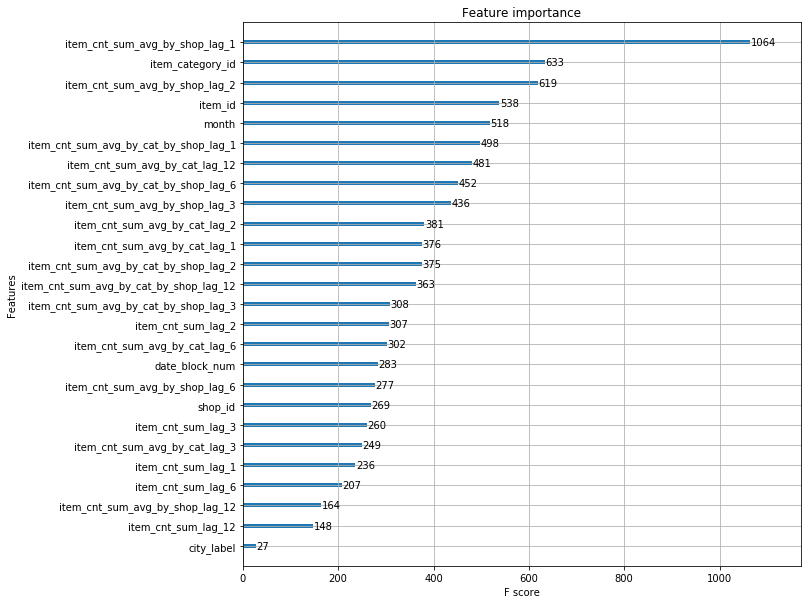

In [7]:
fig, ax = plt.subplots(1, 1, figsize=(10,10))
plot_importance(booster=model, ax=ax)

Now, we put all the training data together and train the final model

In [9]:
x_train = new_train[(new_train.date_block_num >= 12) & (new_train.date_block_num <= 33)]
y_train = x_train[['item_cnt_sum']]
x_train = x_train.drop(columns=['item_cnt_sum']).fillna(0)

x_test = new_train[new_train.date_block_num == 34].drop(columns=['item_cnt_sum']).fillna(0)

In [10]:
model = XGBRegressor(
    n_estimators=50,
    max_depth=8,
    min_child_weight=100, 
    colsample_bytree=0.7, 
    subsample=0.8,
    eta=0.1,    
    seed=42)

# Fit the model
model.fit(
    x_train, 
    y_train, 
    eval_metric="rmse", 
    eval_set=[(x_train, y_train)],
    verbose=True)

[07:23:16] Tree method is automatically selected to be 'approx' for faster speed. to use old behavior(exact greedy algorithm on single machine), set tree_method to 'exact'
[0]	validation_0-rmse:1.15225
[1]	validation_0-rmse:1.10791
[2]	validation_0-rmse:1.06953
[3]	validation_0-rmse:1.03678
[4]	validation_0-rmse:1.00948
[5]	validation_0-rmse:0.986188
[6]	validation_0-rmse:0.965391
[7]	validation_0-rmse:0.947564
[8]	validation_0-rmse:0.932583
[9]	validation_0-rmse:0.920091
[10]	validation_0-rmse:0.909064
[11]	validation_0-rmse:0.899944
[12]	validation_0-rmse:0.892246
[13]	validation_0-rmse:0.885262
[14]	validation_0-rmse:0.879507
[15]	validation_0-rmse:0.87414
[16]	validation_0-rmse:0.869689
[17]	validation_0-rmse:0.865653
[18]	validation_0-rmse:0.861441
[19]	validation_0-rmse:0.857122
[20]	validation_0-rmse:0.854015
[21]	validation_0-rmse:0.85142
[22]	validation_0-rmse:0.84828
[23]	validation_0-rmse:0.846373
[24]	validation_0-rmse:0.844243
[25]	validation_0-rmse:0.842006
[26]	validatio

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.7, eta=0.1, gamma=0, learning_rate=0.1,
       max_delta_step=0, max_depth=8, min_child_weight=100, missing=None,
       n_estimators=50, n_jobs=1, nthread=None, objective='reg:linear',
       random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
       seed=42, silent=True, subsample=0.8)

Save the model

In [11]:
import pickle

pickle.dump(model, open('model_20190628.dat','wb'))

## Create submission

In [12]:
y_test = np.clip(model.predict(x_test), 0, 20)

submission = pd.DataFrame({
    "ID": test.index, 
    "item_cnt_month": y_test
})

submission.to_csv('xgb_submission.csv', index=False)